In [1]:
"""Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis
"""

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np
from stat_functions import all_position_stats, all_rb_defense_headers, all_wide_receiver_quarterback_headers
from get_df import get_running_back_df, get_wide_receiver_df, get_defense_df, all_individual_stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

In [2]:
# df_all_running_backs_2019 = all_position_stats('2019','rushing', 29)
# df_all_running_backs_2019.columns = all_rb_defense_headers('2019','rushing')
# df_all_running_backs_2019.to_pickle("./pickled/df_all_running_backs_2019.pkl")

# Pickling
df_all_running_backs_2019 = pd.read_pickle("./pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']] = df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']].apply(pd.to_numeric)
df_all_running_backs_2019 = df_all_running_backs_2019.sort_values('Yds',ascending=False)
df_all_running_backs_2019


,Link,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb
Derrick Henry,/players/H/HenrDe00.htm,Derrick Henry *,TEN,25,RB,15,15,303,1540,16,73,74,5.1,102.7,5
Nick Chubb,/players/C/ChubNi00.htm,Nick Chubb*,CLE,24,RB,16,16,298,1494,8,62,88,5.0,93.4,3
Christian McCaffrey,/players/M/McCaCh01.htm,Christian McCaffrey *+,CAR,23,RB,16,16,287,1387,15,57,84,4.8,86.7,1
Ezekiel Elliott,/players/E/ElliEz00.htm,Ezekiel Elliott*,DAL,24,RB,16,16,301,1357,12,78,33,4.5,84.8,3
Chris Carson,/players/C/CarsCh00.htm,Chris Carson,SEA,25,RB,15,15,278,1230,7,75,59,4.4,82.0,7
Lamar Jackson,/players/J/JackLa00.htm,Lamar Jackson*+,BAL,22,QB,15,15,176,1206,7,71,47,6.9,80.4,9
Leonard Fournette,/players/F/FourLe00.htm,Leonard Fournette,JAX,24,RB,15,15,265,1152,3,55,81,4.3,76.8,1
Josh Jacobs,/players/J/JacoJo01.htm,Josh Jacobs,OAK,21,RB,13,13,242,1150,7,53,51,4.8,88.5,1
Joe Mixon,/players/M/MixoJo00.htm,Joe Mixon,CIN,23,RB,16,15,278,1137,5,56,41,4.1,71.1,0
Dalvin Cook,/players/C/CookDa01.htm,Dalvin Cook*,MIN,24,RB,14,14,250,1135,13,60,75,4.5,81.1,4


In [3]:
# df_all_wide_receivers_2019 = all_position_stats('2019','receiving', 29)
# df_all_wide_receivers_2019.columns = all_wide_receiver_quarterback_headers('2019','receiving')
# df_all_wide_receivers_2019.to_pickle("./pickled/df_all_wide_receivers_2019.pkl")

# Pickling
df_all_wide_receivers_2019 = pd.read_pickle("./pickled/df_all_wide_receivers_2019.pkl")
df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']] = df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']].apply(pd.to_numeric)
df_all_wide_receivers_2019 = df_all_wide_receivers_2019.sort_values('Yds',ascending=False)
df_all_wide_receivers_2019


,Link,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb
Michael Thomas,/players/T/ThomMi05.htm,Michael Thomas*+,NOR,26,WR,16,15,185,149,80.5%,1725,11.6,9,91,49,9.3,9.3,107.8,1
Julio Jones,/players/J/JoneJu02.htm,Julio Jones *,ATL,30,WR,15,15,157,99,63.1%,1394,14.1,6,77,54,8.9,6.6,92.9,1
Chris Godwin,/players/G/GodwCh00.htm,Chris Godwin*,TAM,23,WR,14,14,121,86,71.1%,1333,15.5,9,63,71,11.0,6.1,95.2,0
Travis Kelce,/players/K/KelcTr00.htm,Travis Kelce*,KAN,30,TE,16,16,136,97,71.3%,1229,12.7,5,65,47,9.0,6.1,76.8,1
Keenan Allen,/players/A/AlleKe00.htm,Keenan Allen*,LAC,27,WR,16,16,149,104,69.8%,1199,11.5,6,63,45,8.0,6.5,74.9,0
Amari Cooper,/players/C/CoopAm00.htm,Amari Cooper*,DAL,25,WR,16,16,119,79,66.4%,1189,15.1,8,54,53,10.0,4.9,74.3,0
D.J. Moore,/players/M/MoorD.00.htm,D.J. Moore,CAR,22,WR,15,15,135,87,64.4%,1175,13.5,4,63,52,8.7,5.8,78.3,2
Jarvis Landry,/players/L/LandJa00.htm,Jarvis Landry*,CLE,27,WR,16,16,138,83,60.1%,1174,14.1,6,55,65,8.5,5.2,73.4,0
DeAndre Hopkins,/players/H/HopkDe00.htm,DeAndre Hopkins*+,HOU,27,WR,15,15,150,104,69.3%,1165,11.2,7,68,43,7.8,6.9,77.7,0
Cooper Kupp,/players/K/KuppCo00.htm,Cooper Kupp,LAR,26,WR,16,14,134,94,70.1%,1161,12.4,10,51,66,8.7,5.9,72.6,3


In [4]:
# df_all_quarterbacks_2019 = all_position_stats('2019','passing', 29)
# df_all_quarterbacks_2019.columns = all_wide_receiver_quarterback_headers('2019','passing')
# df_all_quarterbacks_2019.to_pickle("./pickled/df_all_quarterbacks_2019.pkl")

# Pickling
# pd.set_option('display.max_columns', None)
df_all_quarterbacks_2019 = pd.read_pickle("./pickled/df_all_quarterbacks_2019.pkl")
df_all_quarterbacks_2019 = df_all_quarterbacks_2019.iloc[:,:15]
df_all_quarterbacks_2019[['Cmp','Att','Yds','TD','Int']] = df_all_quarterbacks_2019[['Cmp','Att','Yds','TD','Int']].apply(pd.to_numeric)

df_all_quarterbacks_2019 = df_all_quarterbacks_2019.sort_values('Yds', ascending=False)
df_all_quarterbacks_2019

,Link,Player,Tm,Age,Pos,G,GS,QBrec,Cmp,Att,Cmp%,Yds,TD,TD%,Int
Jameis Winston,/players/W/WinsJa00.htm,Jameis Winston,TAM,25,QB,16,16,7-9-0,380,626,60.7,5109,33,5.3,30
Dak Prescott,/players/P/PresDa01.htm,Dak Prescott,DAL,26,QB,16,16,8-8-0,388,596,65.1,4902,30,5.0,11
Jared Goff,/players/G/GoffJa00.htm,Jared Goff,LAR,25,QB,16,16,9-7-0,394,626,62.9,4638,22,3.5,16
Philip Rivers,/players/R/RivePh00.htm,Philip Rivers,LAC,38,QB,16,16,5-11-0,390,591,66.0,4615,23,3.9,20
Matt Ryan,/players/R/RyanMa00.htm,Matt Ryan,ATL,34,QB,15,15,7-8-0,408,616,66.2,4466,26,4.2,14
Russell Wilson,/players/W/WilsRu00.htm,Russell Wilson *,SEA,31,QB,16,16,11-5-0,341,516,66.1,4110,31,6.0,5
Tom Brady,/players/B/BradTo00.htm,Tom Brady,NWE,42,QB,16,16,12-4-0,373,613,60.8,4057,24,3.9,8
Derek Carr,/players/C/CarrDe02.htm,Derek Carr,OAK,28,QB,16,16,7-9-0,361,513,70.4,4054,21,4.1,8
Carson Wentz,/players/W/WentCa00.htm,Carson Wentz,PHI,27,QB,16,16,9-7-0,388,607,63.9,4039,27,4.4,7
Patrick Mahomes,/players/M/MahoPa00.htm,Patrick Mahomes *,KAN,24,QB,14,14,11-3-0,319,484,65.9,4031,26,5.4,5


In [90]:
# df_all_defense_2019 = all_position_stats('2019', 'opp', 32)
# df_all_defense_2019.columns = all_rb_defense_headers('2019','opp')
# df_all_defense_2019.to_pickle("./pickled/df_all_defense_2019.pkl")

# Pickling
df_all_defense_2019 = pd.read_pickle("./pickled/df_all_defense_2019.pkl")
df_all_defense_2019

,Link,Tm,G,PF,Yds,Ply,Y/P,TO,FL,1stD,...,Yds,TD,Y/A,1stD,Pen,Yds,1stPy,Sc%,TO%,EXP
New England Patriots,/teams/nwe/2019.htm,New England Patriots,16,225,4414,948,4.7,36,11,261,...,1528,7,4.2,72,107,920,39,19.4,17.3,166.75
Buffalo Bills,/teams/buf/2019.htm,Buffalo Bills,16,259,4772,985,4.8,23,9,295,...,1649,12,4.3,93,94,815,33,23.6,12.4,48.85
Baltimore Ravens,/teams/rav/2019.htm,Baltimore Ravens,16,282,4809,921,5.2,25,12,276,...,1494,12,4.4,74,97,795,39,32.9,14.6,21.61
Chicago Bears,/teams/chi/2019.htm,Chicago Bears,16,298,5186,1017,5.1,19,9,306,...,1632,16,3.9,86,113,923,30,31.3,10.6,0.85
Minnesota Vikings,/teams/min/2019.htm,Minnesota Vikings,16,303,5465,1053,5.2,31,14,324,...,1728,8,4.3,78,83,713,31,34.5,17.0,-3.88
Pittsburgh Steelers,/teams/pit/2019.htm,Pittsburgh Steelers,16,303,4866,1030,4.7,38,18,304,...,1753,7,3.8,110,115,1118,30,29.9,19.0,86.78
Kansas City Chiefs,/teams/kan/2019.htm,Kansas City Chiefs,16,308,5594,1043,5.4,23,7,344,...,2051,14,4.9,115,116,844,39,34.6,13.6,-56.69
San Francisco 49ers,/teams/sfo/2019.htm,San Francisco 49ers,16,310,4509,968,4.7,27,15,285,...,1802,11,4.5,105,116,957,30,29.0,14.2,84.41
Green Bay Packers,/teams/gnb/2019.htm,Green Bay Packers,16,313,5642,998,5.7,25,8,310,...,1921,15,4.7,99,97,968,20,34.3,14.0,-59.65
Denver Broncos,/teams/den/2019.htm,Denver Broncos,16,316,5392,1003,5.4,17,7,305,...,1783,9,4.2,96,121,1041,34,37.3,8.4,-31.98


In [91]:
df_all_defense_rush_2019 = df_all_defense_2019.iloc[:,17:20] #+ df_all_defense_2019.iloc[:,7:10]
df_all_defense_rush_2019.sort_values('Yds')

,Att,Yds,TD
Tampa Bay Buccaneers,362,1181,11
New York Jets,417,1391,12
Philadelphia Eagles,353,1442,13
New Orleans Saints,345,1461,12
Baltimore Ravens,340,1494,12
New England Patriots,365,1528,7
Indianapolis Colts,383,1567,8
Oakland Raiders,405,1570,15
Chicago Bears,414,1632,16
Buffalo Bills,388,1649,12


In [6]:
# all_running_back_stats = all_individual_stats(get_running_back_df, df_all_running_backs_2019)

In [78]:
derrick_henry_rb_2019 = get_running_back_df('/players/H/HenrDe00.htm','2019')
derrick_henry_rb_2019.to_pickle("./pickled/derrick_henry_rb_2019.pkl")

# Pickling
derrick_henry_rb_2019 = pd.read_pickle("./pickled/derrick_henry_rb_2019.pkl")
derrick_henry_rb_2019.sort_values('Total_Yards')

,Name,Date,Game,Week,Team,Opp,Result,Carries,Total_Yards,Yards/Carry,Touchdowns
5,Derrick Henry,2019-10-13,6,6,TEN,DEN,L 0-16,15,28,1.87,0
2,Derrick Henry,2019-09-19,3,3,TEN,JAX,L 7-20,17,44,2.59,1
8,Derrick Henry,2019-11-03,9,9,TEN,CAR,L 20-30,13,63,4.85,1
7,Derrick Henry,2019-10-27,8,8,TEN,TAM,W 27-23,16,75,4.69,0
4,Derrick Henry,2019-10-06,5,5,TEN,BUF,L 7-14,20,78,3.90,1
1,Derrick Henry,2019-09-15,2,2,TEN,IND,L 17-19,15,82,5.47,1
0,Derrick Henry,2019-09-08,1,1,TEN,CLE,W 43-13,19,84,4.42,1
13,Derrick Henry,2019-12-15,14,15,TEN,HOU,L 21-24,21,86,4.10,0
6,Derrick Henry,2019-10-20,7,7,TEN,LAC,W 23-20,22,90,4.09,1
3,Derrick Henry,2019-09-29,4,4,TEN,ATL,W 24-10,27,100,3.70,0


&lt;AxesSubplot:xlabel=&#39;Game&#39;, ylabel=&#39;Total_Yards&#39;&gt;

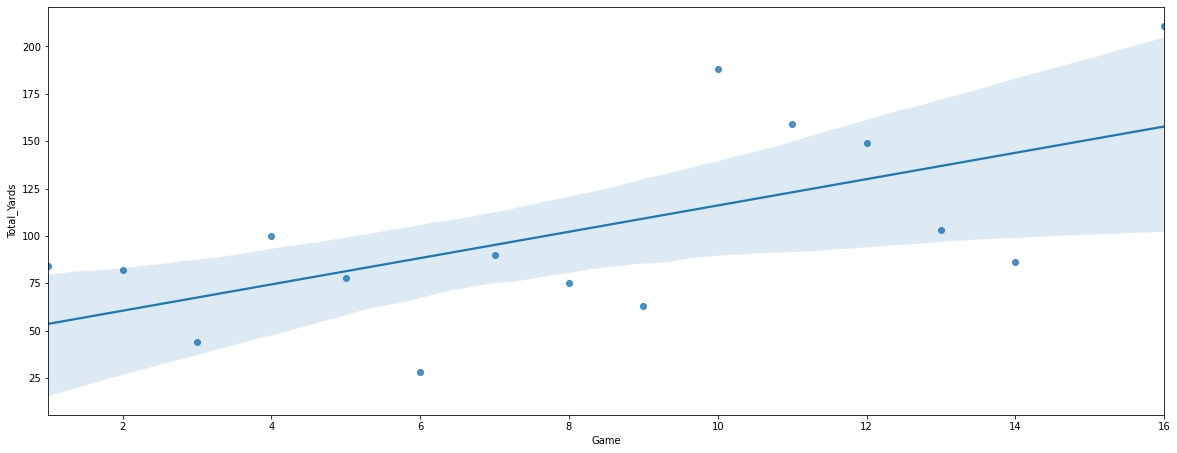

In [8]:
plt.figure(figsize = [20,7.5])
sns.regplot(data=derrick_henry_rb_2019, x="Game", y="Total_Yards")

&lt;seaborn.axisgrid.PairGrid at 0x13f6c7640&gt;

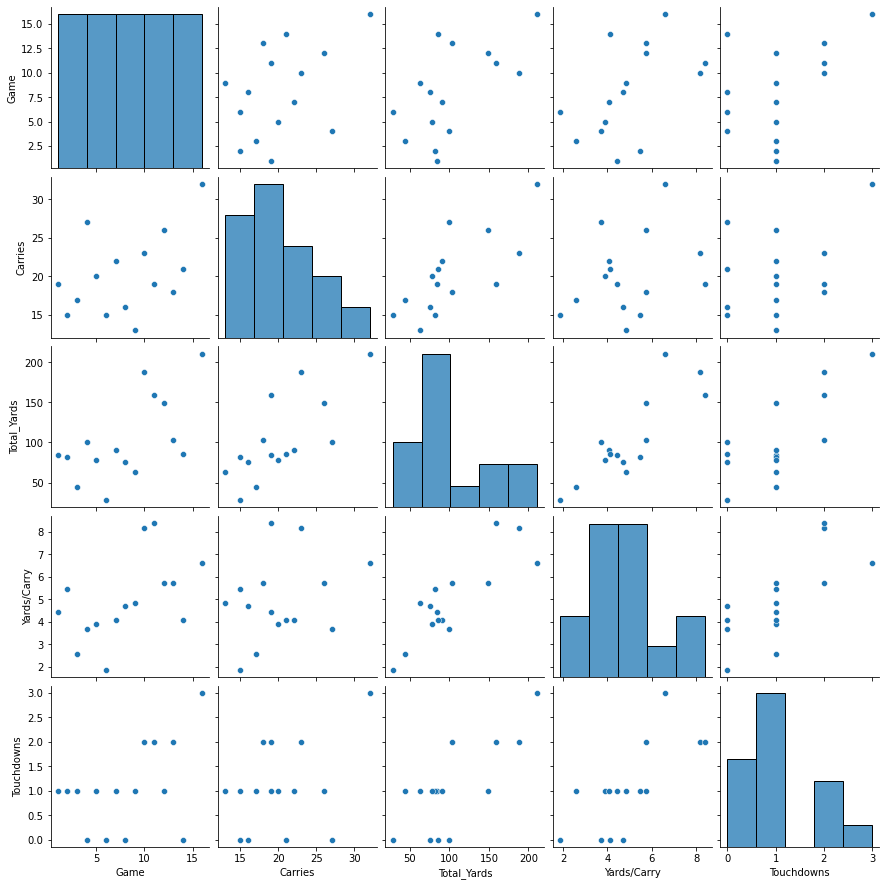

In [9]:
sns.pairplot(data=derrick_henry_rb_2019)

In [10]:
derrick_henry_rb_2020 = get_running_back_df('/players/H/HenrDe00.htm','2020')
derrick_henry_rb_2020.to_pickle("./pickled/derrick_henry_rb_2020.pkl")

# Pickling
derrick_henry_rb_2020 = pd.read_pickle("./pickled/derrick_henry_rb_2020.pkl")
derrick_henry_rb_2020

,Name,Date,Game,Week,Team,Opp,Result,Carries,Total_Yards,Yards/Carry,Touchdowns
0,Derrick Henry,2020-09-14,1,1,TEN,DEN,W 16-14,31,116,3.74,0
1,Derrick Henry,2020-09-20,2,2,TEN,JAX,W 33-30,25,84,3.36,0
2,Derrick Henry,2020-09-27,3,3,TEN,MIN,W 31-30,26,119,4.58,2


In [11]:
# all_wide_receiver_stats = all_individual_stats(get_wide_receiver_df, df_all_wide_receivers_2019)
# all_wide_receiver_stats

In [12]:
# michael_thomas_wr_2019 = get_wide_receiver_df('/players/T/ThomMi05.htm')
# michael_thomas_wr_2019.to_pickle("./pickled/michael_thomas_wr_2019.pkl")

# Pickling
# michael_thomas_wr_2019 = pd.read_pickle("./pickled/michael_thomas_wr_2019.pkl")
# michael_thomas_wr_2019

In [13]:
# dak_prescott_wr_2019 = get_wide_receiver_df('/players/T/ThomMi05.htm')
# michael_thomas_wr_2019.to_pickle("./pickled/michael_thomas_wr_2019.pkl")

# # Pickling
# michael_thomas_wr_2019 = pd.read_pickle("./pickled/michael_thomas_wr_2019.pkl")
# michael_thomas_wr_2019

In [14]:
# plt.figure(figsize = [20,7.5])
# sns.regplot(data=michael_thomas_wr_2019, x="Game", y="Total_Yards")
# plt.figure(figsize = [20,6])

In [15]:
# patriots_2019 = get_defense_df('nwe', '2019')
# patriots_2019 = patriots_2019.drop([9,17,18])
# patriots_2019.to_pickle("./pickled/patriots_2019.pkl")

# # Pickling
patriots_2019 = pd.read_pickle("./pickled/patriots_2019.pkl")
patriots_2019['Game'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
patriots_2019 = patriots_2019[:-1]

In [79]:
patriots_2019

,Team,Day,Date,Opponent,Points,Opponent Score,1stDowns,Defense_Total_Yards,Defense_Pass_Yards,Defense_Rush_Yards,Turnovers,Game
0,New England Patriots,Sun,September 8,Pittsburgh Steelers,33,3,15,308.0,276.0,32.0,1,1
1,New England Patriots,Sun,September 15,Miami Dolphins,43,0,11,184.0,142.0,42.0,4,2
2,New England Patriots,Sun,September 22,New York Jets,30,14,6,105.0,69.0,36.0,1,3
3,New England Patriots,Sun,September 29,Buffalo Bills,16,10,23,375.0,240.0,135.0,4,4
4,New England Patriots,Sun,October 6,Washington Redskins,33,7,11,223.0,78.0,145.0,2,5
5,New England Patriots,Thu,October 10,New York Giants,35,14,10,213.0,161.0,52.0,4,6
6,New England Patriots,Mon,October 21,New York Jets,33,0,12,154.0,73.0,81.0,6,7
7,New England Patriots,Sun,October 27,Cleveland Browns,27,13,15,310.0,151.0,159.0,3,8
8,New England Patriots,Sun,November 3,Baltimore Ravens,20,37,26,372.0,162.0,210.0,2,9
10,New England Patriots,Sun,November 17,Philadelphia Eagles,17,10,21,255.0,174.0,81.0,1,10


&lt;AxesSubplot:xlabel=&#39;Game&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

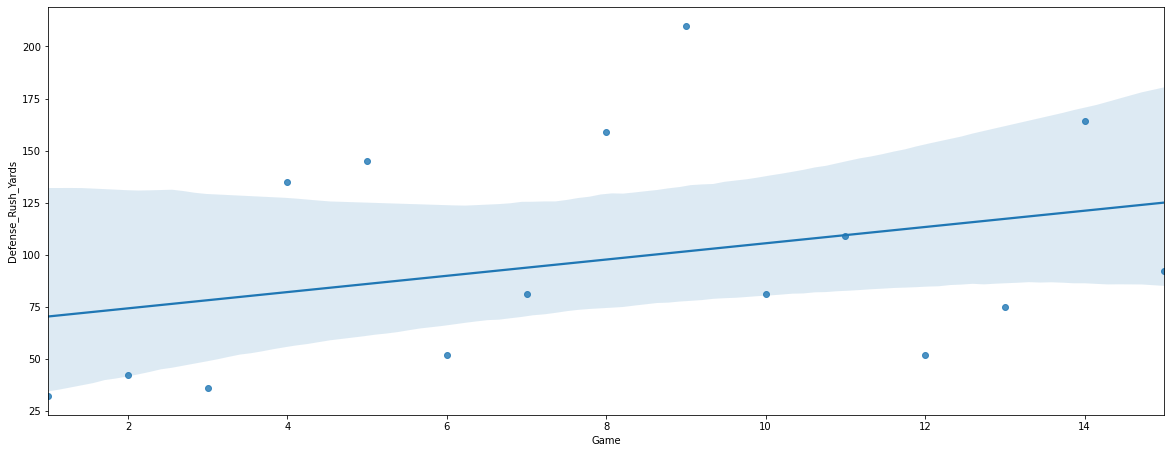

In [17]:
plt.figure(figsize = [20,7.5])
sns.regplot(data=patriots_2019, x="Game", y="Defense_Rush_Yards")

In [50]:
# patriots_2020 = get_defense_df('nwe', '2020')
# patriots_2020.to_pickle("./pickled/patriots_2020.pkl")

# # Pickling
patriots_2020 = pd.read_pickle("./pickled/patriots_2020.pkl")
patriots_2020['Game'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,1]
patriots_2020 = patriots_2020[:3]
patriots_2020

,Team,Day,Date,Opponent,Points,Opponent Score,1stDowns,Defense_Total_Yards,Defense_Pass_Yards,Defense_Rush_Yards,Turnovers,Game
0,New England Patriots,Sun,September 13,Miami Dolphins,21,11,20,269.0,182.0,87.0,3,1
1,New England Patriots,Sun,September 20,Seattle Seahawks,30,35,22,429.0,275.0,154.0,1,2
2,New England Patriots,Sun,September 27,Las Vegas Raiders,36,20,22,375.0,249.0,126.0,3,3


In [140]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [165]:
derrick_henry_rb_2019[:8]

,Name,Date,Game,Week,Team,Opp,Result,Carries,Total_Yards,Yards/Carry,Touchdowns
0,Derrick Henry,2019-09-08,1,1,TEN,CLE,W 43-13,19,84,4.42,1
1,Derrick Henry,2019-09-15,2,2,TEN,IND,L 17-19,15,82,5.47,1
2,Derrick Henry,2019-09-19,3,3,TEN,JAX,L 7-20,17,44,2.59,1
3,Derrick Henry,2019-09-29,4,4,TEN,ATL,W 24-10,27,100,3.70,0
4,Derrick Henry,2019-10-06,5,5,TEN,BUF,L 7-14,20,78,3.90,1
5,Derrick Henry,2019-10-13,6,6,TEN,DEN,L 0-16,15,28,1.87,0
6,Derrick Henry,2019-10-20,7,7,TEN,LAC,W 23-20,22,90,4.09,1
7,Derrick Henry,2019-10-27,8,8,TEN,TAM,W 27-23,16,75,4.69,0


Coefficients: 
 [[ 1.00000000e+00 -7.48674701e-17]
 [-9.48301951e-02  3.44826906e+00]]
Mean squared error: 2480.46
Coefficient of determination: -0.29


[&lt;matplotlib.lines.Line2D at 0x14a521ee0&gt;,
 &lt;matplotlib.lines.Line2D at 0x14a521f40&gt;]

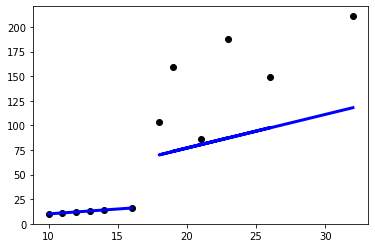

In [213]:
# Use only one feature: Carries/Game for Running Back
# X-Variable
carries_derrick_henry = derrick_henry_rb_2019[['Game','Carries']] # is this right? 

# Split the data into training/testing sets
carries_derrick_henry_train = carries_derrick_henry[:-6]
carries_derrick_henry_test = carries_derrick_henry[-6:]

# Target Variable: Rushing Yards/Game for Running Back
# Y-Variable
yards_derrick_henry = derrick_henry_rb_2019[['Game','Total_Yards']]

# Split the targets into training/testing sets
yards_derrick_henry_train = yards_derrick_henry[:-6]
yards_derrick_henry_test = yards_derrick_henry[-6:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(carries_derrick_henry_train, yards_derrick_henry_train)

# Make predictions using the testing set
yards_derrick_henry_pred = regr.predict(carries_derrick_henry_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(yards_derrick_henry_test, yards_derrick_henry_pred))
# # The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(yards_derrick_henry_test, yards_derrick_henry_pred))

# # Plot outputs
plt.scatter(carries_derrick_henry_test, yards_derrick_henry_test,  color='black')
plt.plot(carries_derrick_henry_test, yards_derrick_henry_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

Coefficients: 
 [[ 1.00000000e+00 -5.13933396e-17]
 [ 2.32279174e-01  1.61422454e+01]]
Mean squared error: 940.24
Coefficient of determination: 0.63


[&lt;matplotlib.lines.Line2D at 0x148d438b0&gt;,
 &lt;matplotlib.lines.Line2D at 0x148d43910&gt;]

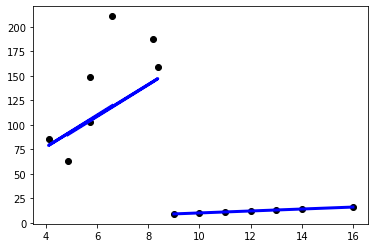

In [216]:
# Use only one feature: Carries/Game for Running Back
# X-Variable
YC_derrick_henry = derrick_henry_rb_2019[['Game','Yards/Carry']] # is this right? 

# Split the data into training/testing sets
YC_derrick_henry_train = YC_derrick_henry[:-7]
YC_derrick_henry_test = YC_derrick_henry[-7:]

# Target Variable: Rushing Yards/Game for Running Back
# Y-Variable
yards_derrick_henry = derrick_henry_rb_2019[['Game','Total_Yards']]

# Split the targets into training/testing sets
yards_derrick_henry_train = yards_derrick_henry[:-7]
yards_derrick_henry_test = yards_derrick_henry[-7:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(YC_derrick_henry_train, yards_derrick_henry_train)

# Make predictions using the testing set
yards_derrick_henry_pred = regr.predict(YC_derrick_henry_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(yards_derrick_henry_test, yards_derrick_henry_pred))
# # The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(yards_derrick_henry_test, yards_derrick_henry_pred))

# # Plot outputs
plt.scatter(YC_derrick_henry_test, yards_derrick_henry_test,  color='black')
plt.plot(YC_derrick_henry_test, yards_derrick_henry_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


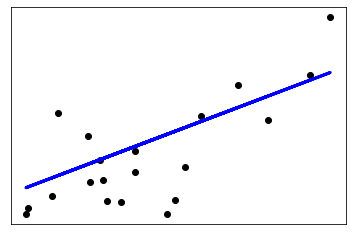

In [184]:
print(__doc__)


# Code source: Jaques Grobler
# License: BSD 3 clause


import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [198]:
diabetes_X_train = diabetes_X[-20:]
diabetes_X_train
# diabetes_X_test = diabetes_X[-20:]
# diabetes_X_test

# # Split the targets into training/testing sets
# diabetes_y_train = diabetes_y[:-20]
# diabetes_y_train
# diabetes_y_test = diabetes_y[-20:]
# diabetes_y_test

array([[ 0.07786339],
       [-0.03961813],
       [ 0.01103904],
       [-0.04069594],
       [-0.03422907],
       [ 0.00564998],
       [ 0.08864151],
       [-0.03315126],
       [-0.05686312],
       [-0.03099563],
       [ 0.05522933],
       [-0.06009656],
       [ 0.00133873],
       [-0.02345095],
       [-0.07410811],
       [ 0.01966154],
       [-0.01590626],
       [-0.01590626],
       [ 0.03906215],
       [-0.0730303 ]])

&lt;AxesSubplot:xlabel=&#39;Total_Yards&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

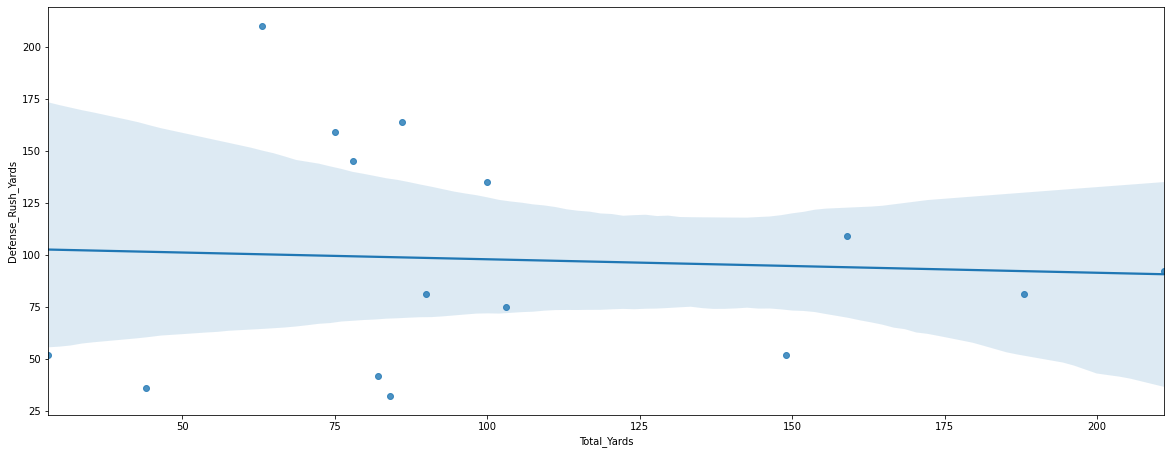

In [67]:
plt.figure(figsize = [20,7.5])

sns.regplot(x=derrick_henry_rb_2019['Total_Yards'], y=patriots_2019['Defense_Rush_Yards'])

&lt;AxesSubplot:xlabel=&#39;Total_Yards&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

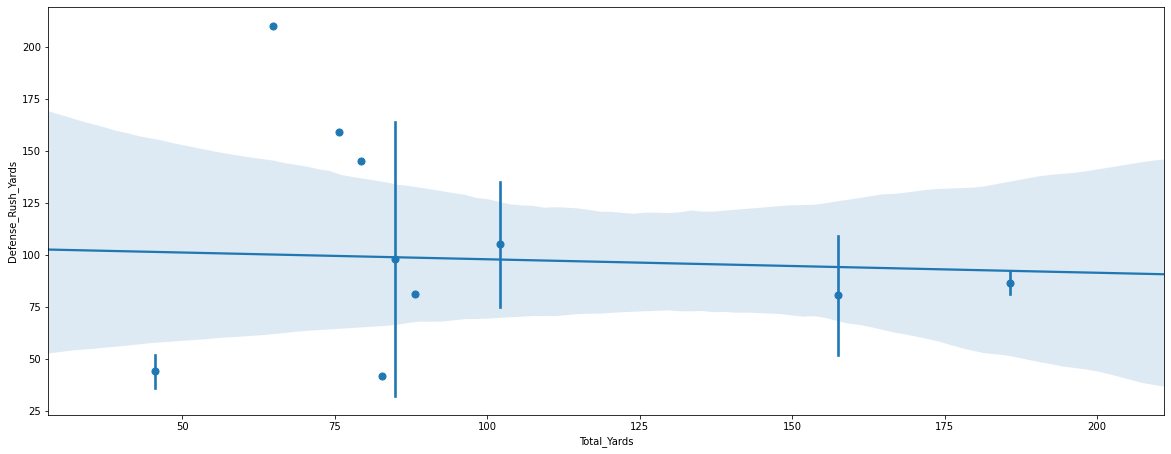

In [74]:
plt.figure(figsize = [20,7.5])

sns.regplot(x=derrick_henry_rb_2019['Total_Yards'], y=patriots_2019['Defense_Rush_Yards'], x_bins=12)

In [111]:
tampa_2019 = get_defense_df('tam', '2019')
tampa_2019 = tampa_2019.drop([6])
tampa_2019.to_pickle("./pickled/tampa_2019.pkl")

# Pickling
tampa_2019 = pd.read_pickle("./pickled/tampa_2019.pkl")
tampa_2019['Game'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
tampa_2019_1 = tampa_2019[:-1]
tampa_2019

,Team,Day,Date,Opponent,Points,Opponent Score,1stDowns,Defense_Total_Yards,Defense_Pass_Yards,Defense_Rush_Yards,Turnovers,Game
0,Tampa Bay Buccaneers,Sun,September 8,San Francisco 49ers,17,31,17,256.0,158.0,98.0,2,1
1,Tampa Bay Buccaneers,Thu,September 12,Carolina Panthers,20,14,20,352.0,313.0,39.0,1,2
2,Tampa Bay Buccaneers,Sun,September 22,New York Giants,31,32,17,384.0,312.0,72.0,2,3
3,Tampa Bay Buccaneers,Sun,September 29,Los Angeles Rams,55,40,36,518.0,490.0,28.0,4,4
4,Tampa Bay Buccaneers,Sun,October 6,New Orleans Saints,24,31,25,457.0,345.0,112.0,1,5
5,Tampa Bay Buccaneers,Sun,October 13,Carolina Panthers,26,37,17,268.0,209.0,59.0,1,6
7,Tampa Bay Buccaneers,Sun,October 27,Tennessee Titans,23,27,16,246.0,174.0,72.0,1,7
8,Tampa Bay Buccaneers,Sun,November 3,Seattle Seahawks,34,40,31,492.0,347.0,145.0,1,8
9,Tampa Bay Buccaneers,Sun,November 10,Arizona Cardinals,30,27,20,417.0,342.0,75.0,2,9
10,Tampa Bay Buccaneers,Sun,November 17,New Orleans Saints,17,34,21,328.0,219.0,109.0,,10


&lt;AxesSubplot:xlabel=&#39;Game&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

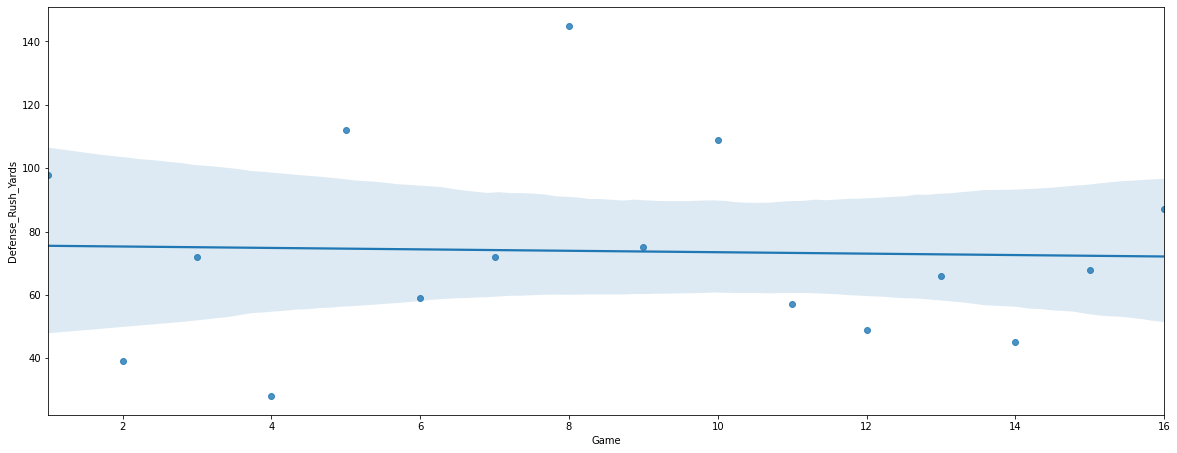

In [112]:
plt.figure(figsize = [20,7.5])
sns.regplot(data=tampa_2019, x="Game", y="Defense_Rush_Yards")

&lt;AxesSubplot:xlabel=&#39;Total_Yards&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

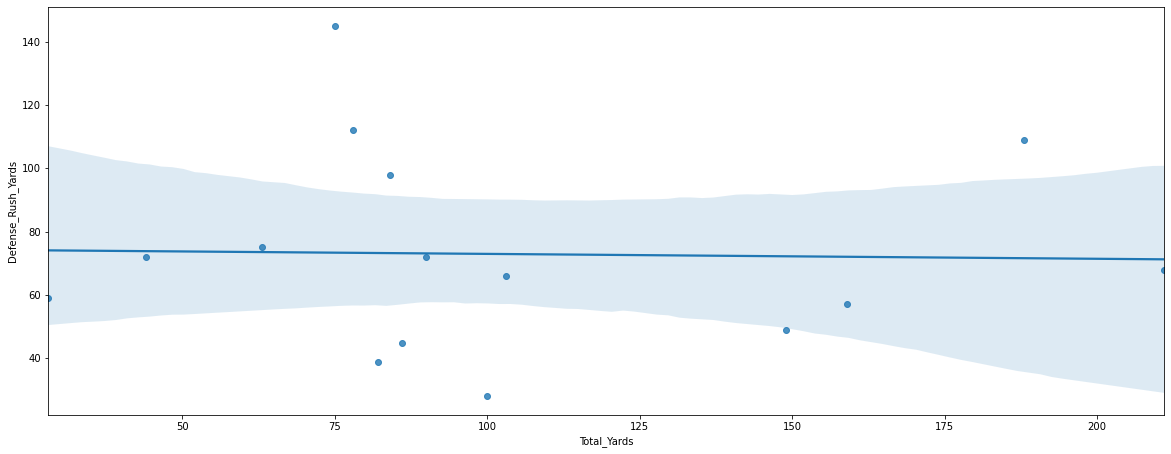

In [119]:
plt.figure(figsize = [20,7.5])

sns.regplot(x=derrick_henry_rb_2019['Total_Yards'], y=tampa_2019_1['Defense_Rush_Yards'])

In [107]:
phillip_lindsay_rb_2019 = get_running_back_df('/players/L/LindPh00.htm','2019')
phillip_lindsay_rb_2019.to_pickle("./pickled/phillip_lindsay_rb_2019.pkl")

# Pickling
phillip_lindsay_rb_2019 = pd.read_pickle("./pickled/phillip_lindsay_rb_2019.pkl")
phillip_lindsay_rb_2019.sort_values('Total_Yards')

,Name,Date,Game,Week,Team,Opp,Result,Carries,Total_Yards,Yards/Carry,Touchdowns
13,Phillip Lindsay,2019-12-15,14,15,DEN,KAN,L 3-23,7,32,4.57,0
1,Phillip Lindsay,2019-09-15,2,2,DEN,CHI,L 14-16,13,36,2.77,0
6,Phillip Lindsay,2019-10-17,7,7,DEN,KAN,L 6-30,11,36,3.27,0
0,Phillip Lindsay,2019-09-09,1,1,DEN,OAK,L 16-24,11,43,3.91,0
12,Phillip Lindsay,2019-12-08,13,14,DEN,HOU,W 38-24,16,51,3.19,1
3,Phillip Lindsay,2019-09-29,4,4,DEN,JAX,L 24-26,9,53,5.89,0
15,Phillip Lindsay,2019-12-29,16,17,DEN,OAK,W 16-15,18,53,2.94,0
10,Phillip Lindsay,2019-11-24,11,12,DEN,BUF,L 3-20,13,57,4.38,0
11,Phillip Lindsay,2019-12-01,12,13,DEN,LAC,W 23-20,17,58,3.41,0
7,Phillip Lindsay,2019-10-27,8,8,DEN,IND,L 13-15,14,59,4.21,0


&lt;AxesSubplot:xlabel=&#39;Game&#39;, ylabel=&#39;Total_Yards&#39;&gt;

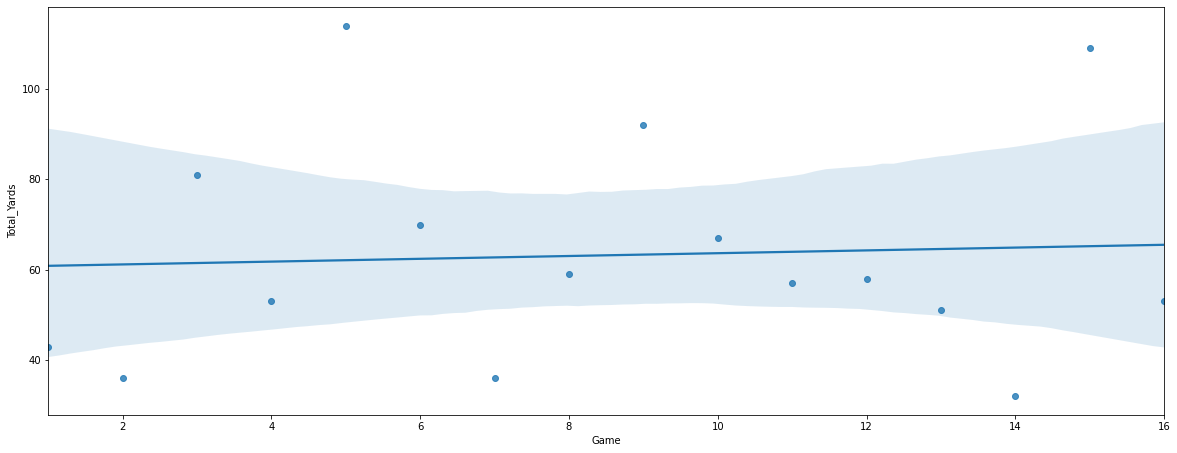

In [109]:
plt.figure(figsize = [20,7.5])
sns.regplot(data=phillip_lindsay_rb_2019, x="Game", y="Total_Yards")

&lt;AxesSubplot:xlabel=&#39;Total_Yards&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

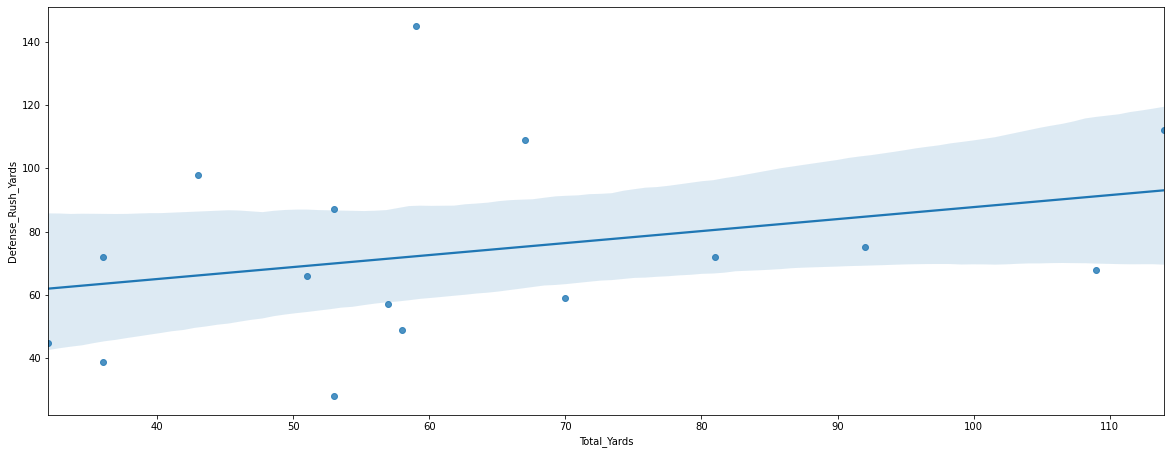

In [117]:
plt.figure(figsize = [20,7.5])

sns.regplot(x=phillip_lindsay_rb_2019['Total_Yards'], y=tampa_2019['Defense_Rush_Yards'])

In [124]:
cin_2019 = get_defense_df('cin', '2019')
cin_2019 = cin_2019.drop([8])
cin_2019.to_pickle("./pickled/cin_2019.pkl")

# Pickling
cin_2019 = pd.read_pickle("./pickled/cin_2019.pkl")
cin_2019['Game'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
cin_2019_1 = cin_2019[:-1]
cin_2019

,Team,Day,Date,Opponent,Points,Opponent Score,1stDowns,Defense_Total_Yards,Defense_Pass_Yards,Defense_Rush_Yards,Turnovers,Game
0,Cincinnati Bengals,Sun,September 8,Seattle Seahawks,20,21,12,232.0,160.0,72.0,1,1
1,Cincinnati Bengals,Sun,September 15,San Francisco 49ers,17,41,27,571.0,312.0,259.0,1,2
2,Cincinnati Bengals,Sun,September 22,Buffalo Bills,17,21,25,416.0,241.0,175.0,2,3
3,Cincinnati Bengals,Mon,September 30,Pittsburgh Steelers,3,27,20,326.0,260.0,66.0,1,4
4,Cincinnati Bengals,Sun,October 6,Arizona Cardinals,23,26,26,514.0,248.0,266.0,,5
5,Cincinnati Bengals,Sun,October 13,Baltimore Ravens,17,23,26,497.0,228.0,269.0,1,6
6,Cincinnati Bengals,Sun,October 20,Jacksonville Jaguars,17,27,22,460.0,244.0,216.0,,7
7,Cincinnati Bengals,Sun,October 27,Los Angeles Rams,10,24,19,470.0,372.0,98.0,,8
9,Cincinnati Bengals,Sun,November 10,Baltimore Ravens,13,49,20,379.0,243.0,136.0,1,9
10,Cincinnati Bengals,Sun,November 17,Oakland Raiders,10,17,20,386.0,273.0,113.0,2,10


&lt;AxesSubplot:xlabel=&#39;Game&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

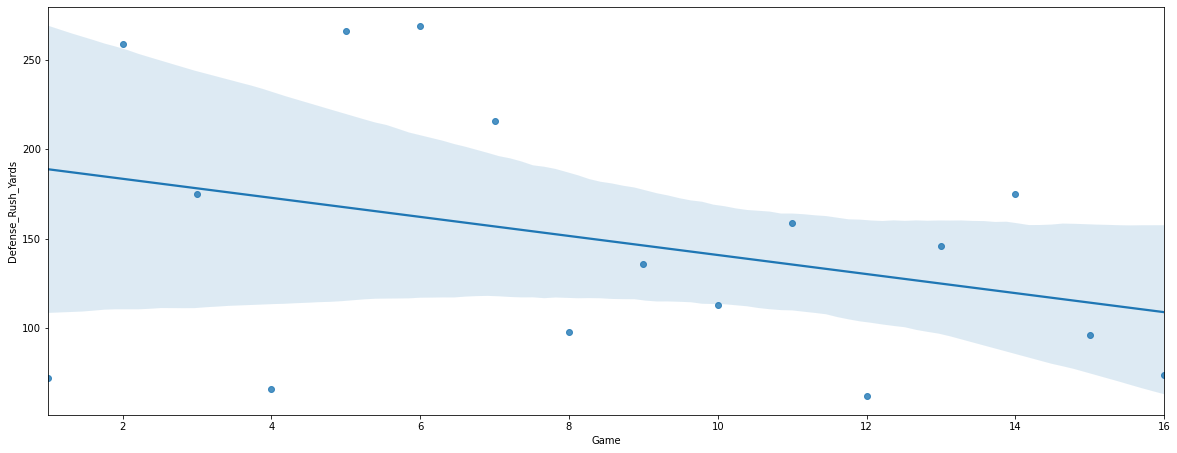

In [133]:
plt.figure(figsize=[20,7.5])

sns.regplot(data=cin_2019, x='Game',y='Defense_Rush_Yards')

&lt;AxesSubplot:xlabel=&#39;Total_Yards&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

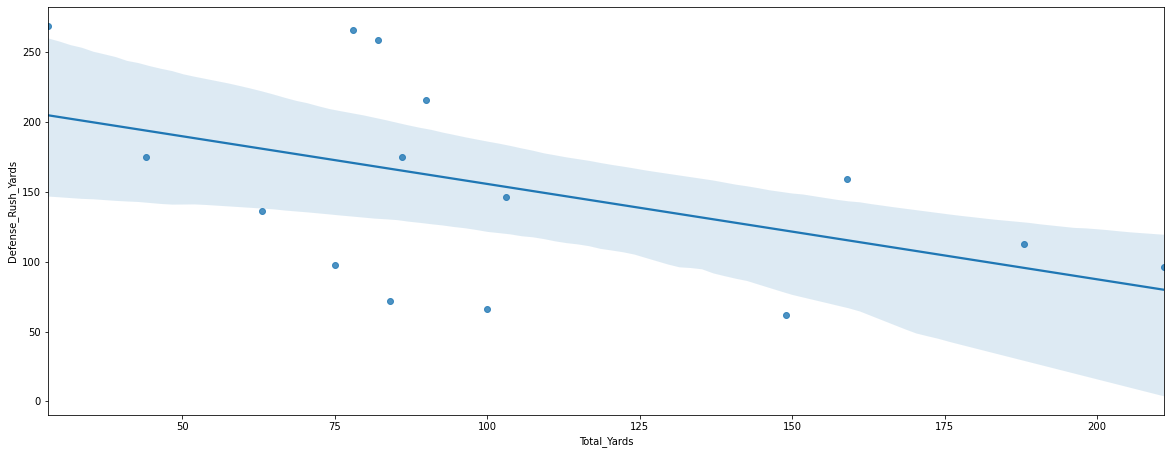

In [137]:
plt.figure(figsize=[20,7.5])

sns.regplot(x=derrick_henry_rb_2019['Total_Yards'], y = cin_2019_1['Defense_Rush_Yards'])

&lt;AxesSubplot:xlabel=&#39;Total_Yards&#39;, ylabel=&#39;Defense_Rush_Yards&#39;&gt;

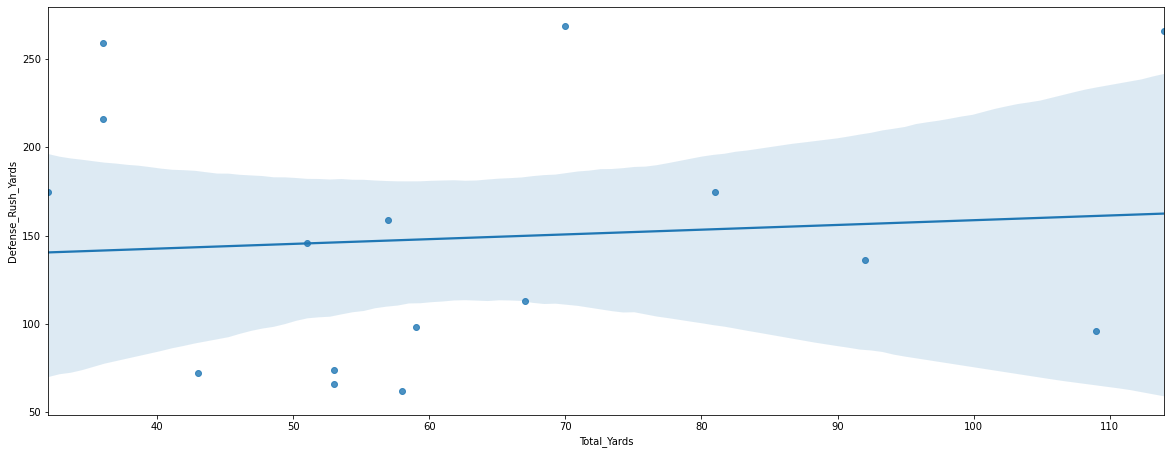

In [139]:
plt.figure(figsize=[20,7.5])

sns.regplot(x=phillip_lindsay_rb_2019['Total_Yards'], y = cin_2019['Defense_Rush_Yards'])